# Crypto Currency Time Series Project 

This notebook aims to deliver a tuned ARIMA model capable of predicting price values of some of the most famous  
crypto currencies based on the past data

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA


# Define the API params

First define the coin to predict, actual date and a past date of n years in the past.  
Lastly define other API params such as currency and number of decimals.

In [2]:
coin = 'ethereum'

In [3]:
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range'

In [4]:
years = 2

In [5]:
today = int(datetime.datetime.now().timestamp())

In [6]:
past_date = int((datetime.datetime.now() - datetime.timedelta(days=365 * years)).timestamp())

In [7]:
params = {'vs_currency': 'usd',
          'from': past_date,
          'to': today,
          'precision': 2}

In [8]:
response = requests.get(url, params=params).json()

In [9]:
df = pd.DataFrame(response["prices"], columns=["Timestamp", "Price"])
df.head()

,Timestamp,Price
0,1636761600000,4685.11
1,1636848000000,4666.50
2,1636934400000,4652.95
3,1637020800000,4583.21
4,1637107200000,4243.35


# Data Cleaning 

Change the date table to a more human readable format, from Timestamp to yyyy-mm-dd

In [10]:
df['Date']= df['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))

In [11]:
df['Timestamp'] = df['Date']

In [12]:
df.drop(columns=['Date'], inplace=True)

In [13]:
df.rename(columns={'Timestamp': 'Date'}, inplace=True)

In [14]:
df['Date']=pd.to_datetime(df['Date'])

In [15]:
df.head()

,Date,Price
0,2021-11-12,4685.11
1,2021-11-13,4666.50
2,2021-11-14,4652.95
3,2021-11-15,4583.21
4,2021-11-16,4243.35


In [16]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

<AxesSubplot:title={'center':'ethereum trend'}, xlabel='Date', ylabel='Price'>

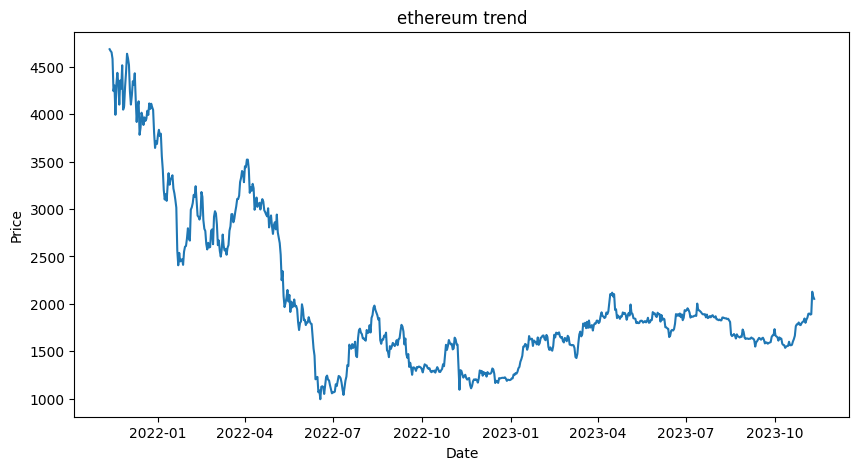

In [17]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend')
sns.lineplot(data=df, x='Date', y='Price')

# SARIMA Grid Search

In [18]:
df['log'] = np.log(df.Price)

<AxesSubplot:title={'center':'ethereum trend log data'}, xlabel='Date', ylabel='log'>

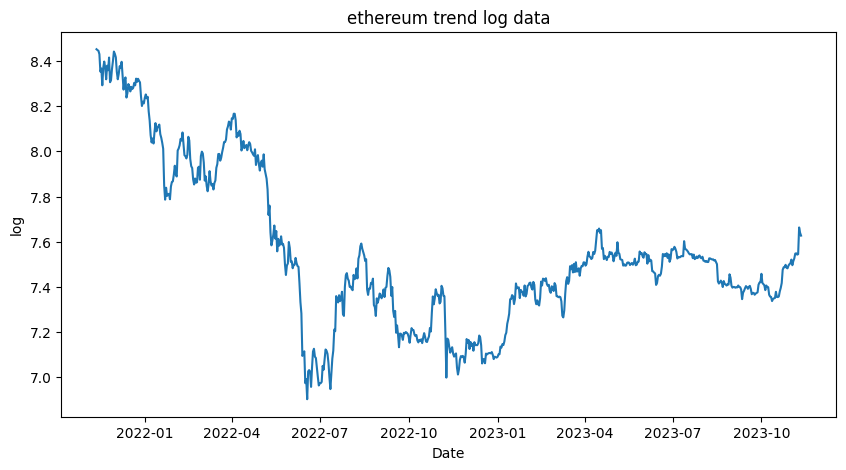

In [19]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend log data')
sns.lineplot(data=df, x='Date', y='log')

In [20]:
len(df)

730

## Train Test Split

In [21]:
train_percentage = int(0.8*(len(df)))

In [22]:
train_percentage

584

In [23]:
# Create train test split
train = df.log[:train_percentage]
test = df.log[train_percentage:]

## Testing Stationarity and finding seasonality

Text(0.5, 1.0, '1st Order Differencing')

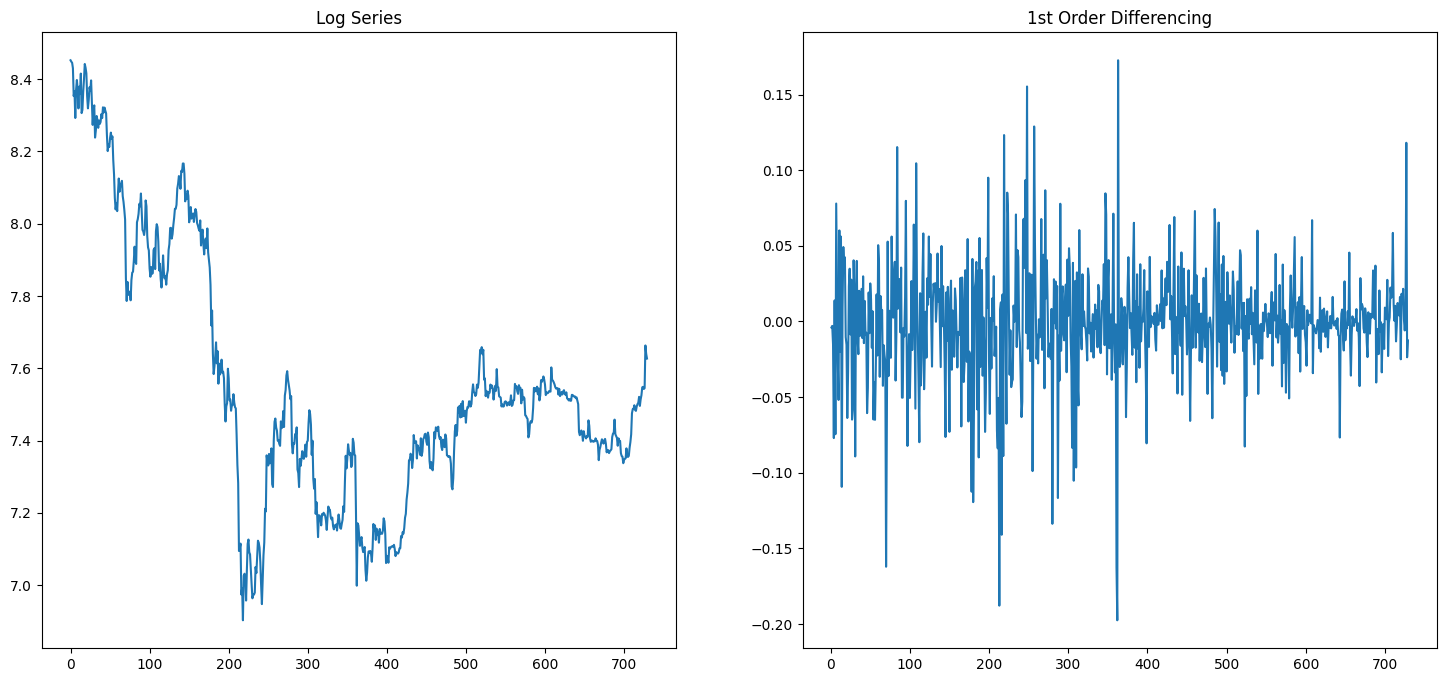

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))


# Log series
axs[0].plot(df.log); axs[0].set_title('Log Series')

# Normal differencing
axs[1].plot(df.log.diff(1)); axs[1].set_title('1st Order Differencing')


In [25]:
# P Value for trusting stationarity 
adfuller(df.log)[1]  # Original data

0.09451365220021124

In [26]:
# P Value for trusting stationarity 
adfuller(df.log.diff(1).dropna())[1]  # First order diff

4.357540836878707e-27

In [27]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(train)

1

In [28]:
price_diff =df.log.diff(1).dropna()

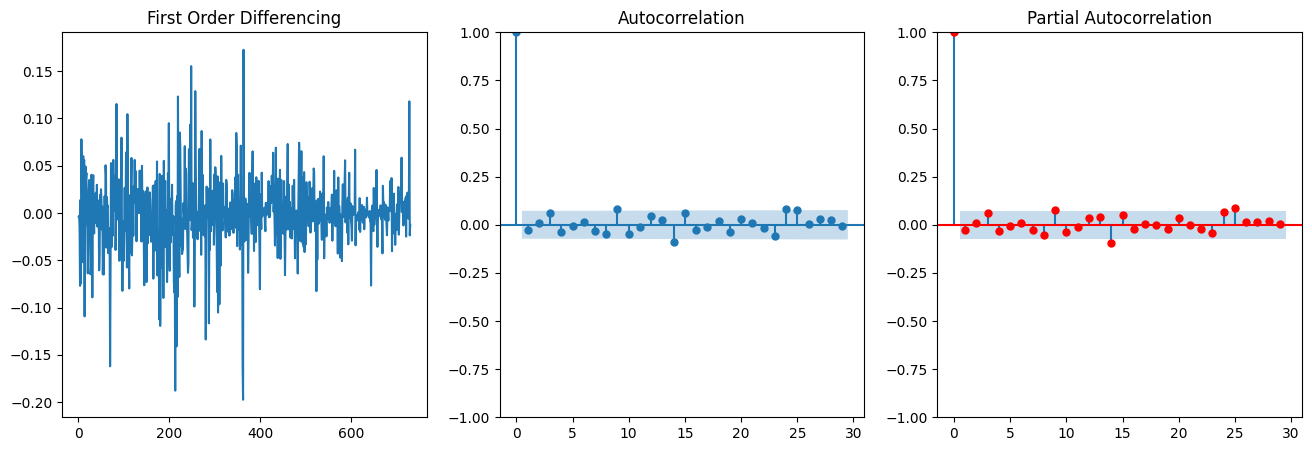

In [29]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].plot(price_diff)
axes[0].set_title('First Order Differencing')
plot_acf(price_diff, ax=axes[1]);
plot_pacf(price_diff, ax=axes[2], c='r');

In [30]:
#Grid Search
smodel = pm.auto_arima(train, seasonal = False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2077.031, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2074.537, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2072.881, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2072.874, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2075.497, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2075.251, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2068.931, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2073.962, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2074.444, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2070.543, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2069.916, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2069.769, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2071.283, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-2077.909, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0

In [31]:
predictions_sm = smodel.predict(len(test), return_conf_int=True)

In [32]:
p, d, q = smodel.order

# Build Model and Predict

In [33]:


# 1. initialize the model
arima = ARIMA(train, order=(p, d, q))

# 2. fit the models
arima = arima.fit()

arima.summary()

/Users/leonardomichelramirez/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    log   No. Observations:                  584
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1043.954
Date:                Sat, 11 Nov 2023   AIC                          -2077.909
Time:                        20:50:19   BIC                          -2056.068
Sample:                             0   HQIC                         -2069.396
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9249      0.046    -19.944      0.000      -1.016      -0.834
ar.L2         -0.9439      0.050    -18.791      0.000      -1.042      -0.845
ma.L1          0.8901      0.059     15.014      0.000       0.774       1.006
ma.L2          0.9036      0.061     14.788      0.000       0.784       1.023
sigma2         0.0016    6.1e-05     26.680      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               281.30
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Statsmodels Forecast

In [34]:
# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast_stats = forecast_results.predicted_mean
confidence_stats = forecast_results.conf_int().values

/Users/leonardomichelramirez/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [35]:
confidence_stats

array([[7.37060478, 7.52879567],
       [7.33721412, 7.55707131],
       [7.31599411, 7.58293672],
       [7.2946873 , 7.60477524],
       [7.27438261, 7.62020341],
       [7.26054134, 7.63805289],
       [7.24524069, 7.65424943],
       [7.22901601, 7.66586221],
       [7.21797289, 7.68032506],
       [7.20559989, 7.69388844],
       [7.19161766, 7.70354188],
       [7.18208256, 7.71595689],
       [7.17153696, 7.72792491],
       [7.15905814, 7.73636986],
       [7.15046564, 7.7473505 ],
       [7.14119743, 7.75821756],
       [7.12983827, 7.76584386],
       [7.12188816, 7.7757372 ],
       [7.1135714 , 7.78578018],
       [7.10310162, 7.79281925],
       [7.09561653, 7.80184789],
       [7.08803696, 7.81123812],
       [7.07830437, 7.81783917],
       [7.07117232, 7.82615837],
       [7.06417907, 7.83500952],
       [7.05507565, 7.8412741 ],
       [7.04822283, 7.84899878],
       [7.04170449, 7.85739034],
       [7.03314923, 7.86339019],
       [7.02652551, 7.87060918],
       [7.

In [36]:
lower_stats = pd.Series(confidence_stats[:,0], index=test.index)
upper_stats = pd.Series(confidence_stats[:,1], index=test.index)

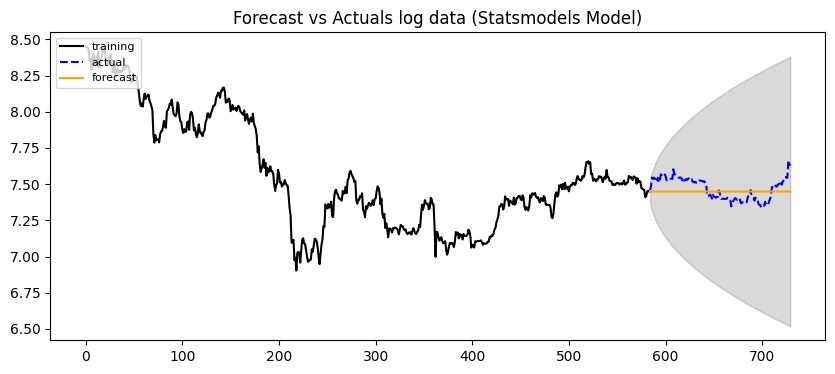

In [37]:
# Plot
plt.figure(figsize=(10,4), dpi=100)
plt.plot(train, label='training', color='black')
plt.plot(test, label='actual', color='blue', ls='--')
plt.plot(forecast_stats, label='forecast', color='orange')
plt.fill_between(lower_stats.index, lower_stats, upper_stats, color='k', alpha=.15)
plt.title('Forecast vs Actuals log data (Statsmodels Model)')
plt.legend(loc='upper left', fontsize=8);

In [38]:
# Re-compose back to initial TS

forecast_recons_stats = np.exp(forecast_stats)
train_recons_stats = np.exp(train)
test_recons_stats = np.exp(test)
lower_recons_stats = np.exp(lower_stats)
upper_recons_stats = np.exp(upper_stats)

## Stats Model Forecast

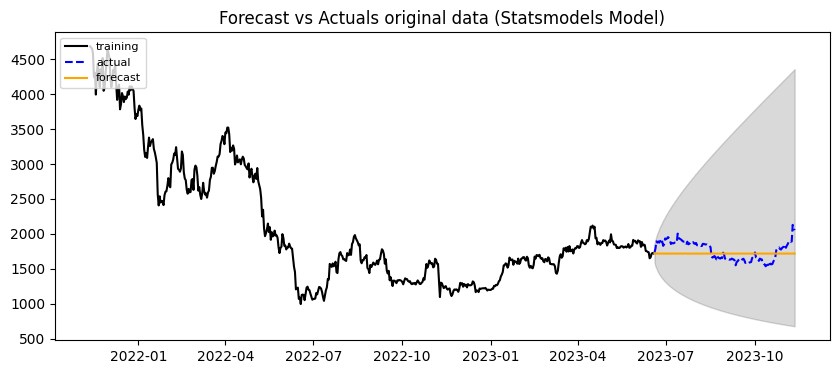

In [39]:
# Plot Original TS and forecast
plt.figure(figsize=(10,4), dpi=100)
plt.plot(df.Date[:train_percentage],train_recons_stats, label='training', color='black')
plt.plot(df.Date[train_percentage:],test_recons_stats, label='actual', color='blue', ls='--')
plt.plot(df.Date[train_percentage:],forecast_recons_stats,label='forecast', color='orange')
plt.fill_between(df.Date[train_percentage:], lower_recons_stats, upper_recons_stats, color='k', alpha=.15)
plt.title('Forecast vs Actuals original data (Statsmodels Model)')
plt.legend(loc='upper left', fontsize=8);

## pmdarima Forecast

In [40]:
forecast_pm = predictions_sm[0]

In [41]:
lower_pm = pd.Series(predictions_sm[1][:,0], index=test.index)
upper_pm = pd.Series(predictions_sm[1][:,1], index=test.index)

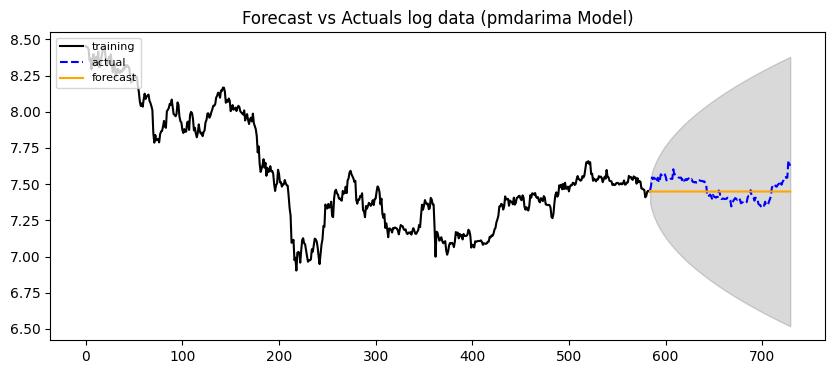

In [42]:
# Plot
plt.figure(figsize=(10,4), dpi=100)
plt.plot(train, label='training', color='black')
plt.plot(test, label='actual', color='blue', ls='--')
plt.plot(forecast_pm, label='forecast', color='orange')
plt.fill_between(lower_pm.index, lower_pm, upper_pm, color='k', alpha=.15)
plt.title('Forecast vs Actuals log data (pmdarima Model)')
plt.legend(loc='upper left', fontsize=8);

In [43]:
# Re-compose back to initial TS

forecast_recons_pm = np.exp(forecast_pm)
train_recons_pm = np.exp(train)
test_recons_pm = np.exp(test)
lower_recons_pm = np.exp(lower_pm)
upper_recons_pm = np.exp(upper_pm)

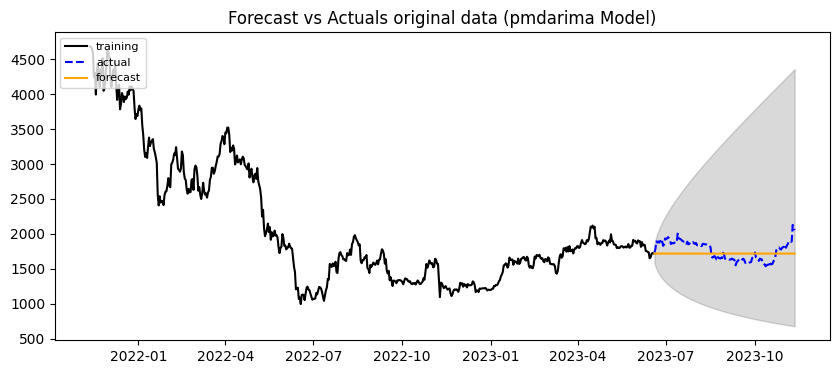

In [46]:
# Plot Original TS and forecast
plt.figure(figsize=(10,4), dpi=100)
plt.plot(df.Date[:train_percentage],train_recons_pm, label='training', color='black')
plt.plot(df.Date[train_percentage:],test_recons_pm, label='actual', color='blue', ls='--')
plt.plot(df.Date[train_percentage:],forecast_recons_pm,label='forecast', color='orange')
plt.fill_between(df.Date[train_percentage:], lower_recons_pm, upper_recons_pm, color='k', alpha=.15)
plt.title('Forecast vs Actuals original data (pmdarima Model)')
plt.legend(loc='upper left', fontsize=8);